In [1]:
import sys
sys.path.append('..')

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pandas as pd
import graph_tool as gt
from graph_tool import centrality, inference
from tqdm import tqdm
from operator import itemgetter
from functools import reduce
import itertools
import networkx as nx
#from py3plex.core import multinet
#from py3plex.core import random_generators

import MuxVizPy as mxp

import gseapy as gp

import warnings
warnings.filterwarnings("ignore")


#set.seed(1)

# input data settings
NEIGH_ORDER = 1 # or 0, order of nerighbors, 0 only connected proteins, 1 also first neighbors
CUT_THR = 0.7   # don't change this one

target_folder = "../Data/Virus_data_Enriched_"+str(CUT_THR)+"_Neigh_"+str(NEIGH_ORDER)+"/"

# multilayer settings
layerCouplingStrength = 1
networkOfLayersType = "categorical" ## = all to all

#virus metadata
virus_metadata = pd.read_csv("../Data/Files/viruses_metadata.csv", header=0, sep=";")

virus_metadata_onco = virus_metadata[virus_metadata["isOncogenic"] == True].reset_index()
virus_metadata_nonco = virus_metadata[virus_metadata["isOncogenic"] == False].reset_index()

#dictionary containing a unquie mapping between name of the protein and a corresponding index
node_map_df = pd.read_csv("../Data/Files/node_map.csv")
node_map_dict = {k:(v-1) for k,v in zip(node_map_df["Prot"], node_map_df["Index"])}

#function to create list of n_iter combination of nonco virus indexes with a fixed random seed for repitibility
def SamplingForNoco(n_iter, start=0, group_dim=8):
    np.random.seed(1234)
    nonco_cond = np.where(np.all([np.array(virus_metadata["virus"]!="Human_SARS_coronavirus_2"),
                                  np.array(virus_metadata["neigh_order"]==NEIGH_ORDER), 
                                  np.array(virus_metadata["isOncogenic"]==False)],
                                  axis=0))
    
    nonco_sampling = np.array([np.random.choice(nonco_cond[0], group_dim, replace=False) for i in range(n_iter+start)])
    
    return nonco_sampling[start:(n_iter+start)]

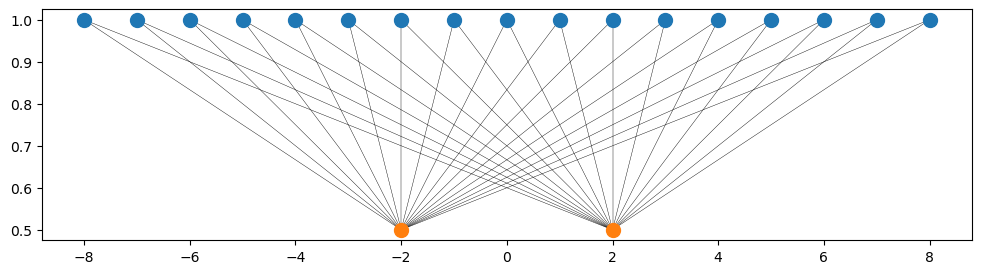

In [20]:
xi = np.arange(17)-8
xo = [-2,2]
yi = [1]*17
yo =[0.5]*2

plt.figure(figsize=(12,3))
plt.scatter(xi,yi,zorder=1, s=100)
plt.scatter(xo,yo,zorder=1, s=100)
for i in range(17):
    plt.plot([xi[i],xo[0]], [yi[i],yo[0]], color="k",lw=0.3,zorder=0)
    plt.plot([xi[i],xo[1]], [yi[i],yo[1]], color="k",lw=0.3,zorder=0)

In [ ]:
alex_df = pd.read_csv("../Data/Alexis_things/Multilayer.edges", sep=" ")

In [233]:
def exctract_nets_from_extended_edgelist(dfEdges, Layers, Nodes):
    #Nodes = np.unique(dfEdges[["NodeIN","NodeOUT"]]).shape[0]
    #Layers = np.unique(dfEdges[["LayerIN","LayerOUT"]]).shape[0]
    g_list=[]
    for i in range(Layers):
        filt_edges = dfEdges[np.all([dfEdges["LayerIN"]==i, dfEdges["LayerOUT"]==i], axis=0)]
        tmp_multi = filt_edges.reset_index()[["NodeIN", "NodeOUT"]]
        tmp_multi = tmp_multi.rename({"NodeIN":"source", "NodeOUT":"target"}, axis=1)
        g=gt.Graph(directed=False)
        g.add_edge_list(tmp_multi.values)
        g.add_vertex(Nodes-g.num_vertices())
        g_list.append(g)
    return g_list

In [2]:
np.random.seed(17876)
nets = []
for i in range(3):
    n_edges = np.random.randint(5,15)
    df_edg = pd.DataFrame({"NodeIN":np.random.randint(0,10,n_edges),
                           "NodeOUT":np.random.randint(0,10,n_edges),})
    gp = gt.Graph(directed=False)
    gp.add_edge_list(df_edg.values)
    gp.add_vertex(10-gp.num_vertices())
    nets.append(gp)

In [3]:
for g in nets:
    g.add_vertex(1)

In [4]:
print(len(mxp.topology.get_multi_LCC(nets)))
print(len(mxp.topology.get_multi_LIC(nets)))
print(len(mxp.topology.get_multi_LVC(nets, printt=False)))

10
4
2


In [5]:
layT=mxp.build.build_layers_tensor(3,1,"categorical")
nodeT=mxp.build.get_node_tensor_from_network_list(nets)

In [6]:
sup=mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodeT, layT, 3, 11)

In [7]:
RW = mxp.topology.multi_custom_walk(sup, 11, 3, walk_len=50)

In [8]:
import matplotlib.patches as mpatches

# Define the colors for the legend
colors = ['C0', 'C1', 'C2']

# Create the legend handles
legend_handles = [mpatches.Patch(color=color, label=f'Layer {i+1}') for i, color in enumerate(colors)]

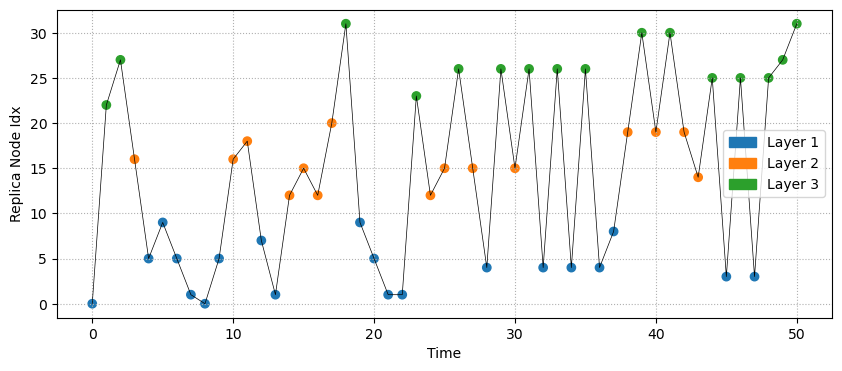

In [9]:
plt.figure(figsize=(10,4))
plt.plot(RW['data']['time'],RW['data']['node'], "k", lw=0.5)
plt.scatter(RW['data']['time'],RW['data']['node'],c=["C"+str(RW['data']['layer'][i]) for i in range(51)])
plt.grid(ls=":")
plt.xlabel("Time")
plt.ylabel("Replica Node Idx")
plt.legend(handles=legend_handles)

In [34]:
RW['data']['node']

0      0
1     22
2     27
3     16
4      5
5      9
6      5
7      1
8      0
9      5
10    16
11    18
12     7
13     1
14    12
15    15
16    12
17    20
18    31
19     9
20     5
21     1
22     1
23    23
24    12
25    15
26    26
27    15
28     4
29    26
30    15
31    26
32     4
33    26
34     4
35    26
36     4
37     8
38    19
39    30
40    19
41    30
42    19
43    14
44    25
45     3
46    25
47     3
48    25
49    27
50    31
Name: node, dtype: int64

In [11]:
positions = gt.draw.sfdp_layout(nets[0]).get_2d_array([0,1])

In [12]:
positions[0][mxp.topology.get_multi_LCC(nets)]

array([ 0.17567738,  1.18665411, -2.69663359, -1.39389639, -2.42368069,
        0.17796327,  2.13470315,  2.27701341, -2.583661  , -0.54163019])

In [42]:
freq_n = np.zeros(33)
freq_n[np.unique(RW['data']['node'], return_counts=True)[0]] = np.unique(RW['data']['node'], return_counts=True)[1]

In [43]:
freq_n

array([2., 4., 0., 2., 4., 4., 0., 1., 1., 2., 0., 0., 3., 0., 1., 4., 2.,
       0., 1., 3., 1., 0., 1., 1., 0., 3., 5., 2., 0., 0., 2., 2., 0.])

In [45]:
freq_n = dict(zip(np.arange(33), freq_n))

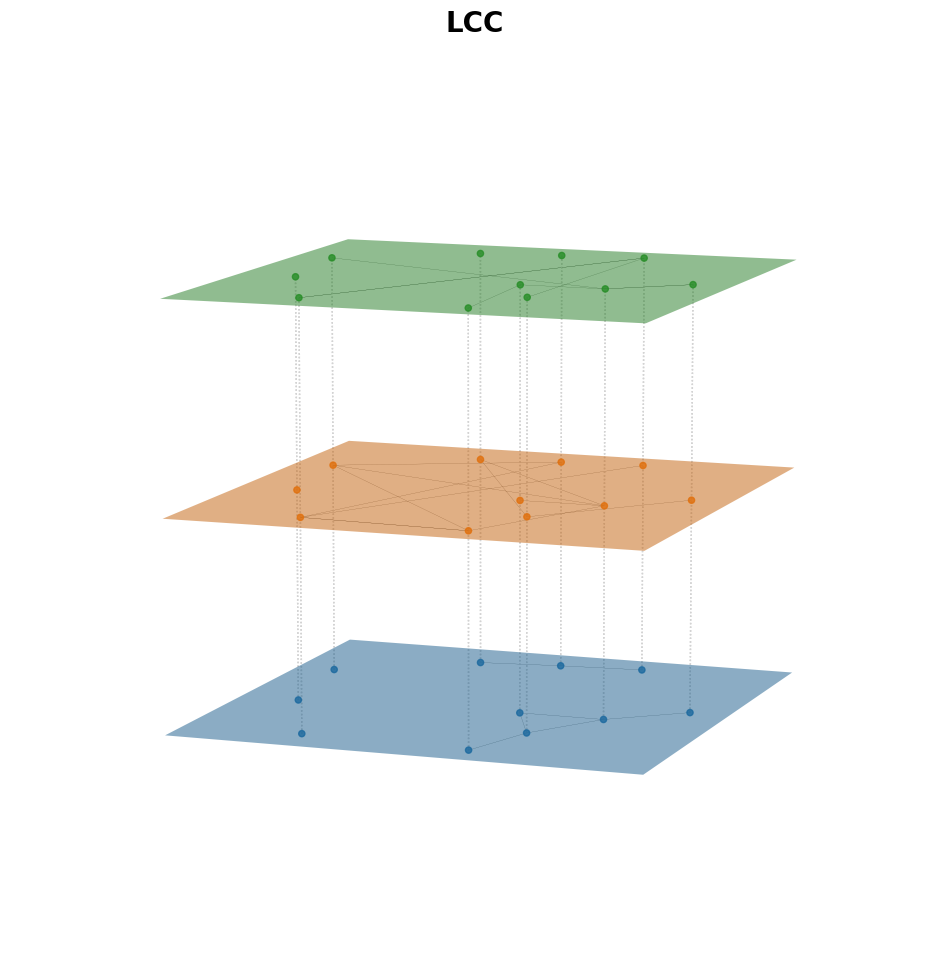

In [52]:
x_width = positions[0].max()-positions[0].min()
y_width = positions[1].max()-positions[1].min()

ax = plt.figure(figsize=(12,15)).add_subplot(projection='3d')
xx, yy = np.meshgrid(np.linspace(positions[0].min()-x_width*0.1, positions[0].max()+x_width*0.1,2), np.linspace(positions[1].min()-y_width*0.1, positions[1].max()+y_width*0.1,2))
X =  xx
Y =  yy

for i in range(len(nets)):
    #ax.scatter(positions[0][mxp.topology.get_multi_LCC(nets)], positions[1][mxp.topology.get_multi_LCC(nets)], zs=i, zdir='z', label=str(np.arange(4)[i]), alpha=1, marker="*", s=50)
    ax.scatter(positions[0], positions[1], zs=i, zdir='z', label=str(np.arange(4)[i]), alpha=0.8, color="C"+str(i))
    for e in nets[i].get_edges():
        ax.plot([positions[0][e[0]], positions[0][e[1]]],[positions[1][e[0]],positions[1][e[1]]] ,zs=[i,i], c="k", lw=0.1)
    for nod in range(nets[0].num_vertices()):
        ax.plot([positions[0][nod], positions[0][nod]],[positions[1][nod],positions[1][nod]] ,zs=[0,len(nets)-1], c="lightgray", lw=1, ls=":")
    Z =  i*np.ones(X.shape)
    ax.plot_surface(X,Y,Z, rstride=1, cstride=1, alpha=0.5)

freq_n = dict(zip(*np.unique(RW['data']['node'], return_counts=True)))
progr_dist = np.zeros(33)
for k in range(51):
    rn = RW['data']['node'][k]
    pn = (RW['data']['node']-11*RW['data']['layer'])[k]
    ll = RW['data']['layer'][k]
    #ax.text(positions[0][pn],positions[1][pn],ll-(0.07*progr_dist[rn]),str(RW['data']['time'][k]),fontsize=10)
    if freq_n[rn]>1:
        
        progr_dist[rn]+=1
    
    
ax.set_xlim(positions[0].min()-x_width*0.2, positions[0].max()+x_width*0.2)
ax.set_zlim(0, len(nets)-1)
ax.set_ylim(positions[1].min()-y_width*0.2, positions[1].max()+y_width*0.2)
ax.axis("off")
plt.title("LCC", fontweight="bold", fontsize=20)
ax.view_init(elev=10, azim=20)

plt.show()


array([ True,  True])

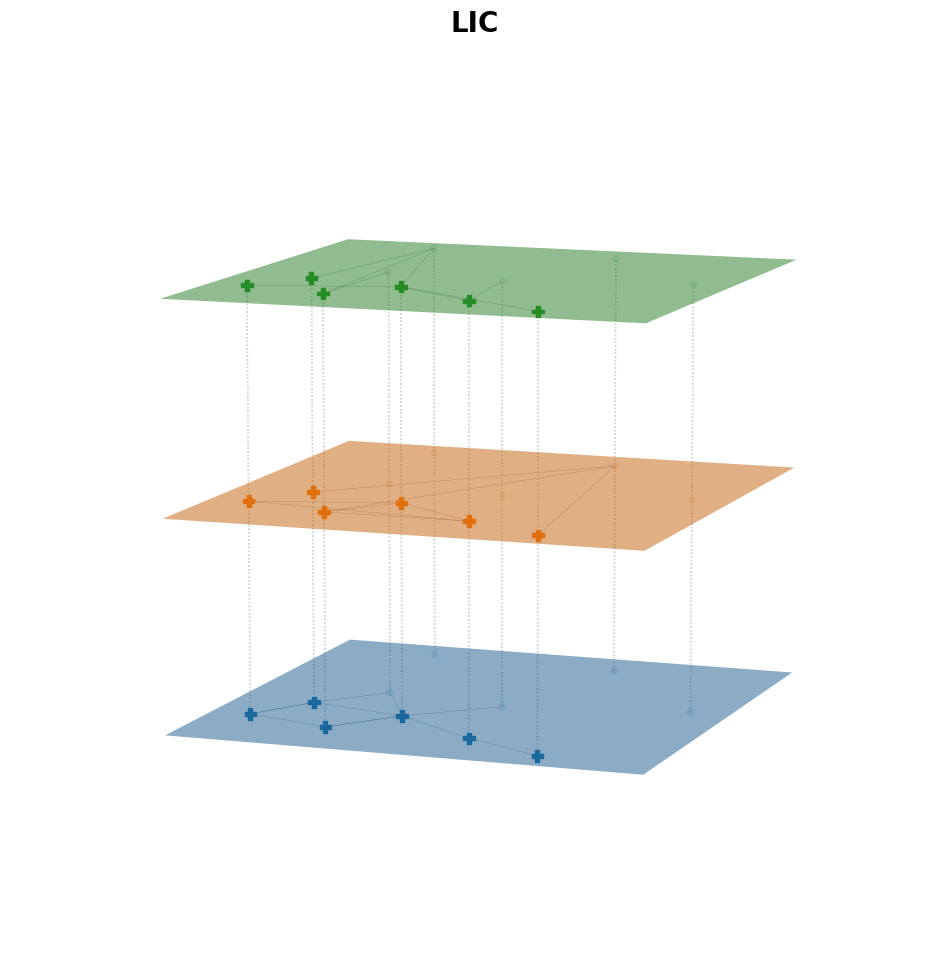

In [275]:
x_width = positions[0].max()-positions[0].min()
y_width = positions[1].max()-positions[1].min()

ax = plt.figure(figsize=(12,15)).add_subplot(projection='3d')
xx, yy = np.meshgrid(np.linspace(positions[0].min()-x_width*0.1, positions[0].max()+x_width*0.1,2), np.linspace(positions[1].min()-y_width*0.1, positions[1].max()+y_width*0.1,2))
X =  xx
Y =  yy

for i in range(len(nets)):
    ax.scatter(positions[0][mxp.topology.get_multi_LIC(nets)], positions[1][mxp.topology.get_multi_LIC(nets)], zs=i, zdir='z', label=str(np.arange(4)[i]), alpha=1, marker="P", s=70, color="C"+str(i))
    #ax.scatter(positions[0][mxp.topology.get_multi_LIC(nets)], positions[1][mxp.topology.get_multi_LIC(nets)], zs=i, zdir='z', label=str(np.arange(4)[i]), alpha=1, marker="^", s=50, color="C"+str(i))
    #ax.scatter(positions[0][mxp.topology.get_multi_LVC(nets, printt=False)], positions[1][mxp.topology.get_multi_LVC(nets, printt=False)], zs=i, zdir='z', label=str(np.arange(4)[i]), alpha=1, marker="P", s=50, color="C"+str(i))
    ax.scatter(positions[0], positions[1], zs=i, zdir='z', label=str(np.arange(4)[i]), alpha=0.1, color="C"+str(i))
    for e in nets[i].get_edges():
        ax.plot([positions[0][e[0]], positions[0][e[1]]],[positions[1][e[0]],positions[1][e[1]]] ,zs=[i,i], c="k", lw=0.1)
    for nod in range(nets[0].num_vertices()):
        ax.plot([positions[0][nod], positions[0][nod]],[positions[1][nod],positions[1][nod]] ,zs=[0,len(nets)-1], c="lightgray", lw=1, ls=":")
    Z =  i*np.ones(X.shape)
    ax.plot_surface(X,Y,Z, rstride=1, cstride=1, alpha=0.5)


ax.set_xlim(positions[0].min()-x_width*0.2, positions[0].max()+x_width*0.2)
ax.set_zlim(0, len(nets)-1)
ax.set_ylim(positions[1].min()-y_width*0.2, positions[1].max()+y_width*0.2)
ax.axis("off")
plt.title("LIC", fontweight="bold", fontsize=20)
ax.view_init(elev=10, azim=20)

plt.show()


In [249]:
mxp.topology.get_multi_LVC(nets, printt=False)

array([7, 9], dtype=int32)

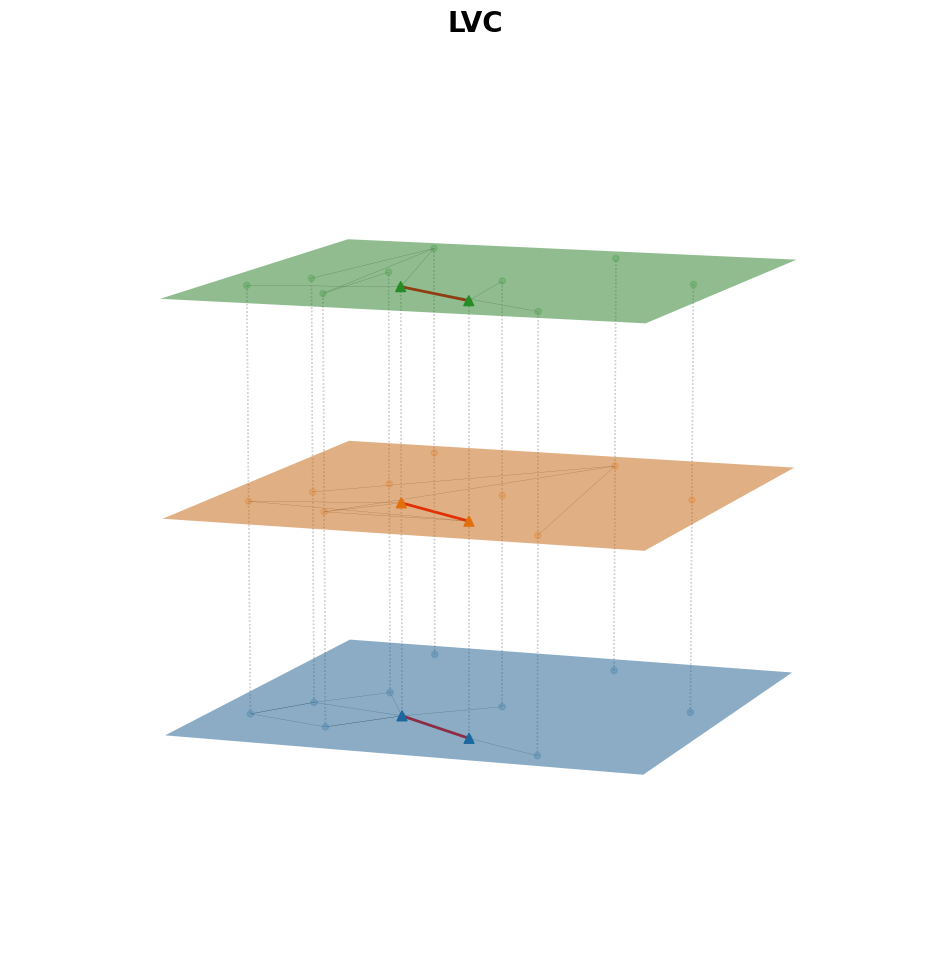

In [274]:
x_width = positions[0].max()-positions[0].min()
y_width = positions[1].max()-positions[1].min()

ax = plt.figure(figsize=(12,15)).add_subplot(projection='3d')
xx, yy = np.meshgrid(np.linspace(positions[0].min()-x_width*0.1, positions[0].max()+x_width*0.1,2), np.linspace(positions[1].min()-y_width*0.1, positions[1].max()+y_width*0.1,2))
X =  xx
Y =  yy

for i in range(len(nets)):
    ax.scatter(positions[0][mxp.topology.get_multi_LVC(nets, printt=False)], positions[1][mxp.topology.get_multi_LVC(nets, printt=False)], zs=i, zdir='z', label=str(np.arange(4)[i]), alpha=1, marker="^", s=50)
    ax.scatter(positions[0], positions[1], zs=i, zdir='z', label=str(np.arange(4)[i]), alpha=0.2, color="C"+str(i))
    for e in nets[i].get_edges():
        ax.plot([positions[0][e[0]], positions[0][e[1]]],[positions[1][e[0]],positions[1][e[1]]] ,zs=[i,i], c="k", lw=0.1)
    for nod in range(nets[0].num_vertices()):
        ax.plot([positions[0][nod], positions[0][nod]],[positions[1][nod],positions[1][nod]] ,zs=[0,len(nets)-1], c="lightgray", lw=1, ls=":")
    Z =  i*np.ones(X.shape)
    ax.plot_surface(X,Y,Z, rstride=1, cstride=1, alpha=0.5)

    ax.plot([positions[0][7], positions[0][9]],[positions[1][7],positions[1][9]] ,zs=[i,i], c="red", lw=2)
ax.set_xlim(positions[0].min()-x_width*0.2, positions[0].max()+x_width*0.2)
ax.set_zlim(0, len(nets)-1)
ax.set_ylim(positions[1].min()-y_width*0.2, positions[1].max()+y_width*0.2)
ax.axis("off")
plt.title("LVC", fontweight="bold", fontsize=20)
ax.view_init(elev=10, azim=20)

plt.show()


In [2]:
nets = exctract_nets_from_extended_edgelist(df_edg, 4,40)

NameError: name 'exctract_nets_from_extended_edgelist' is not defined

NameError: name 'topnodes' is not defined

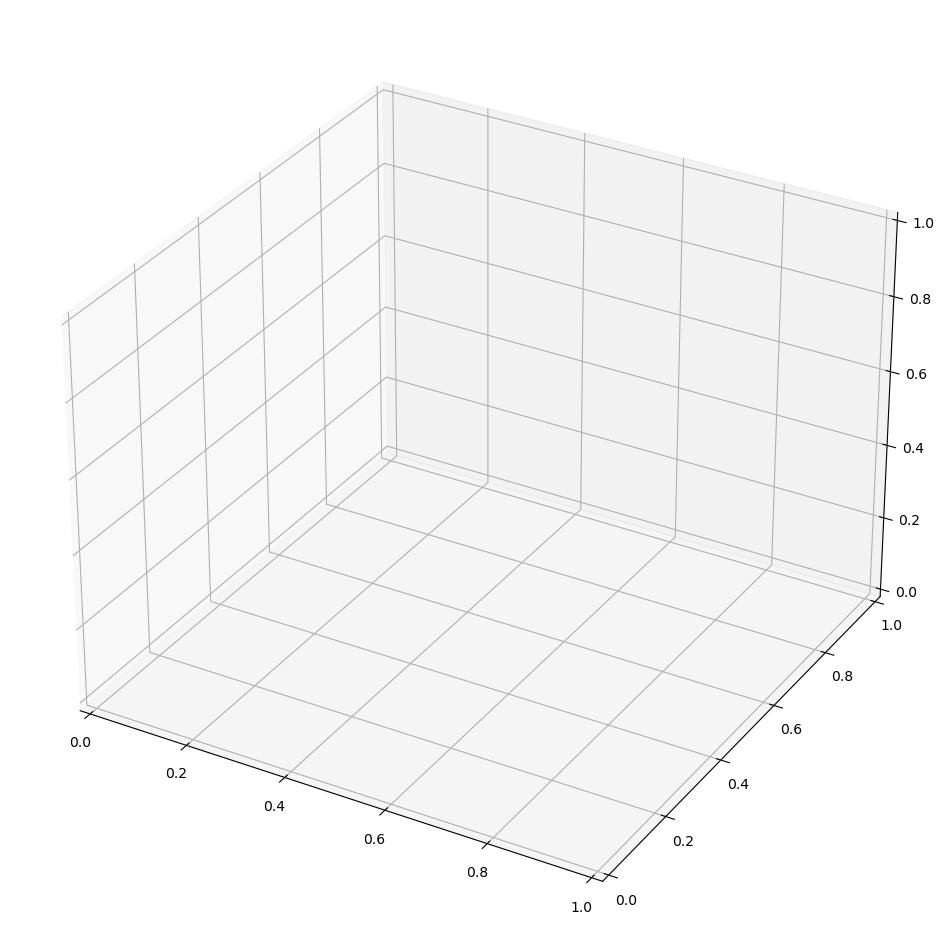

In [246]:



#positions = gt.draw.sfdp_layout(gf_list[pos_idx]).get_2d_array([0,1])

x_width = positions[0].max()-positions[0].min()
y_width = positions[1].max()-positions[1].min()

ax = plt.figure(figsize=(12,15)).add_subplot(projection='3d')
xx, yy = np.meshgrid(np.linspace(positions[0].min()-x_width*0.1, positions[0].max()+x_width*0.1,2), np.linspace(positions[1].min()-y_width*0.1, positions[1].max()+y_width*0.1,2))
X =  xx
Y =  yy

df_filt = df_edg[np.all([np.isin(df_edg["NodeIN"],topnodes),np.isin(df_edg["NodeOUT"],topnodes)], axis=0)]
for i in range(len(nets)):
    #ax.text(positions[0].min()-x_width*0.2, positions[1].max()-y_width*0.2,i, net.virus_list[i])
    ax.scatter(positions[0], positions[1], zs=i, zdir='z', label=str(np.arange(4)[i]), alpha=0.8)
    
    df_filt[np.any([df_filt["NodeIN"]==topnodes[0],df_filt["NodeOUT"]==topnodes[0]], axis=0)]
    Z =  i*np.ones(X.shape)
    ax.plot_surface(X,Y,Z, rstride=1, cstride=1, alpha=0.5)

edges = np.array([df_filt["NodeIN"].to_numpy(), df_filt["NodeOUT"].map(topnmap).to_numpy(), df_filt["LayerIN"], df_filt["LayerOUT"]]).T

for e in df_edg.to_numpy():
    ax.plot([positions[0][e[0]], positions[0][e[1]]],[positions[1][e[0]],positions[1][e[1]]] ,zs=[e[2],e[3]], c="k", lw=0.1)
    
    
ax.set_xlim(positions[0].min()-x_width*0.2, positions[0].max()+x_width*0.2)
ax.set_zlim(0, len(nets)-1)
ax.set_ylim(positions[1].min()-y_width*0.2, positions[1].max()+y_width*0.2)
ax.axis("off")

ax.view_init(elev=10, azim=20)

plt.show()


In [3]:
net = mxp.VirusMultiplex(SamplingForNoco(10, group_dim=4)[9], target_folder=target_folder, virus_metadata=virus_metadata)

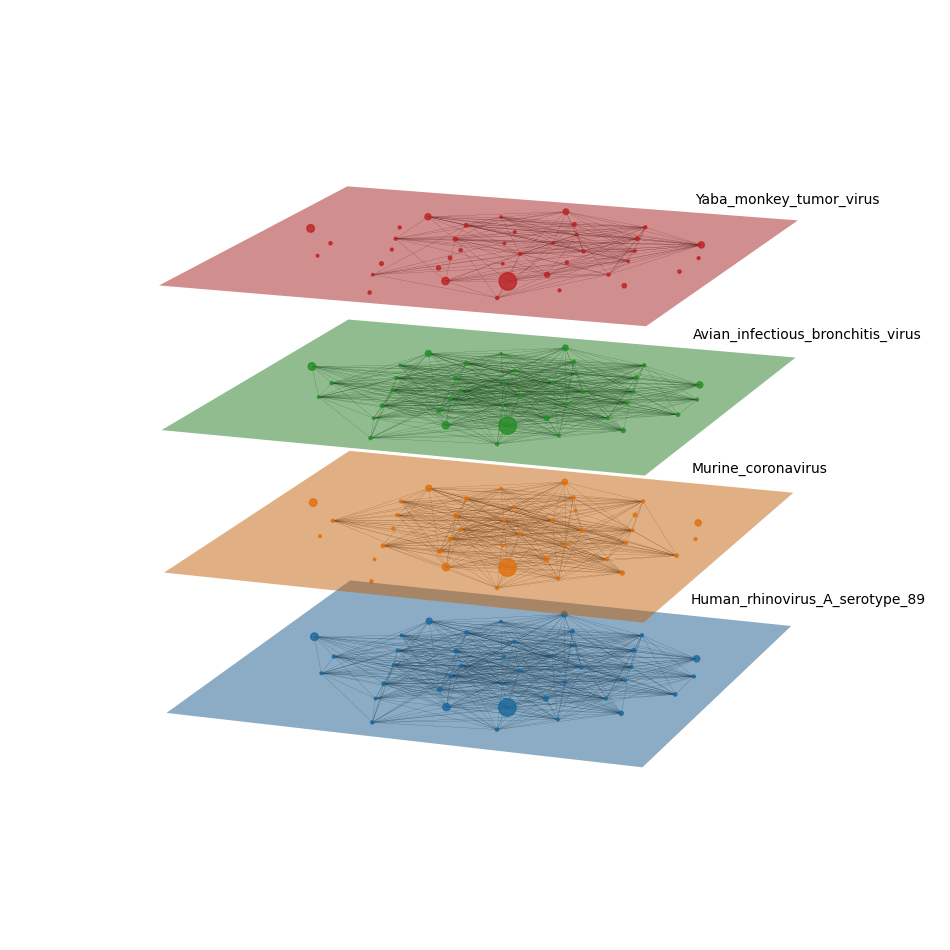

In [4]:
mxp.visualization.Visualize_EdgeColoredNet(net, n_nodes=40, azim=20, elev=15, pos_idx="agg")

In [5]:
net = mxp.VirusMultiplex(SamplingForNoco(10, group_dim=7)[9], target_folder=target_folder, virus_metadata=virus_metadata)

In [ ]:
nT = mxp.build.get_node_tensor_from_network_list(net.g_list)
centr = mxp.versatility.get_multi_RW_centrality_edge_colored(nT)

In [ ]:
order = centr.sort_values("vers")["phy nodes"].to_numpy()

In [ ]:
perc = mxp.percolation.get_percolation(net.g_list, 4, net.Nodes, order=order)

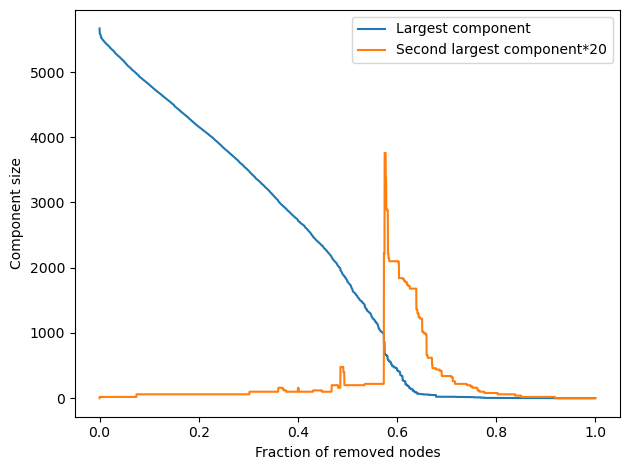

In [92]:
plt.plot(np.linspace(0,1,len(perc['1ComponentSize'])),perc['1ComponentSize'][::-1], label="Largest component")
plt.plot(np.linspace(0,1,len(perc['1ComponentSize'])),perc['2ComponentSize'][::-1]*20, label="Second largest component*20")
plt.xlabel("Fraction of removed nodes")
plt.ylabel("Component size")
plt.legend()
plt.tight_layout()

In [8]:
from graph_tool.draw import cairo_draw
from matplotlib import cm

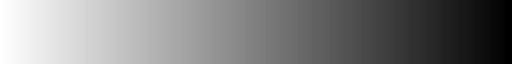

In [271]:
cm.binary

In [13]:
net = mxp.VirusMultiplex(SamplingForNoco(10, group_dim=1)[9], target_folder=target_folder, virus_metadata=virus_metadata)

g = net.g_list[0]

pos = gt.draw.sfdp_layout(net.g_list[0])
positions = pos.get_2d_array([0,1])

In [193]:
g1=gt.Graph(directed=False)
g1.add_vertex(10)

<generator object Graph.add_vertex.<locals>.<genexpr> at 0x7f6e79ae94d0>

In [35]:
np.random.seed(123456)
def sample_k(max):
    accept = False
    while not accept:
        k = np.random.randint(1,max+1)
        accept = np.random.random() < 1.0/k
    return k
g = gt.generation.random_graph(15, lambda: sample_k(10),
                    directed=False,
                    n_iter=100)



In [36]:

pos = gt.draw.sfdp_layout(g)
positions = pos.get_2d_array([0,1])

In [289]:
np.random.seed(1234)

pr = gt.centrality.pagerank(g)
#pr.a = pr.a-min(pr.a)
#pr.a = pr.a/max(pr.a)
bet = gt.centrality.betweenness(g)[0]
eig = gt.centrality.eigenvector(g)[1]
deg = g.degree_property_map("total")

In [290]:
deg = g.new_vertex_property("double")
deg.a = g.degree_property_map("total").a.astype(np.double)
deg.a = deg.a-min(deg.a)
deg.a = deg.a/max(deg.a)

In [295]:
sel_nodes = np.random.randint(1,100,10)

In [303]:
gw = gt.GraphView(g, (np.isin(g.num_vertices(), sel_nodes)))

In [329]:
first_neigh_nodes_rep=[]
for vi in sel_nodes:
    first_neigh_nodes_rep.append(g.get_all_neighbors(vi))
first_neigh_nodes=np.unique(np.concatenate([np.concatenate(first_neigh_nodes_rep), sel_nodes]))

# mask which tells which proteins in the human genome are the NN found above
neighbors_mask = np.isin(np.arange(g.num_vertices()), first_neigh_nodes)

# create vertex property map to remeber which node corresponds to which protein
labels = g.new_vertex_property("int", np.arange(g.num_vertices()))
g.vertex_properties["labels"]=labels

# create a view of a graph and hide all the vertices not in the mask
gw = gt.GraphView(g, vfilt=neighbors_mask)
# then create a new graph in which the hidden nodes are pruned
gf = gt.Graph(gw, prune=True)
#by doing these you can retrive the original names
original_index_nodes = gf.vp["labels"].get_array()

In [330]:
sel_nodes

array([48, 84, 39, 54, 77, 25, 16, 50, 24, 27])

In [331]:
original_index_nodes

PropertyArray([ 6,  7,  9, 12, 14, 16, 21, 24, 25, 26, 27, 32, 37, 39, 43,
               48, 50, 53, 54, 55, 57, 58, 61, 62, 65, 69, 72, 74, 77, 79,
               84, 92, 95, 99], dtype=int32)

In [332]:
p_nn = [positions[0][original_index_nodes], positions[1][original_index_nodes]]

(-7.709716979560385,
 1.1026216379583536,
 -0.39946893159009517,
 6.840249923721233)

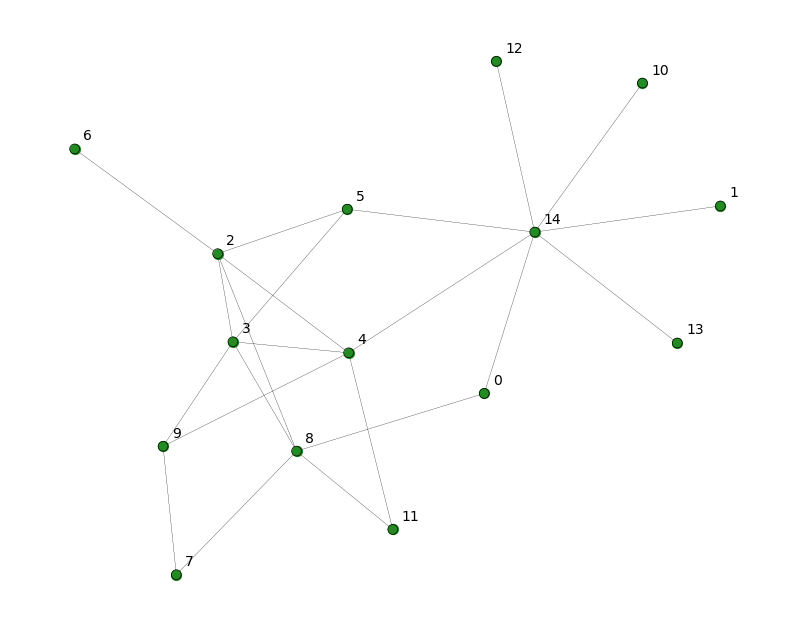

In [49]:
#gw = gt.GraphView(g, np.isin(np.arange(g.num_vertices()), sel_nodes))
#gn = gt.Graph(gw, prune=True)
#size=np.maximum(0.1,g.get_total_degrees(np.arange(gn.num_vertices())))

#p_new = [positions[0][sel_nodes], positions[1][sel_nodes]]
plt.figure(figsize=(10,8))
for e in g.get_edges():
    plt.plot([positions[0][e[0]], positions[0][e[1]]],[positions[1][e[0]], positions[1][e[1]]], c="k", lw=0.2,zorder=0)
#for e in gf.get_edges():
#    plt.plot([p_nn[0][e[0]], p_nn[0][e[1]]],[p_nn[1][e[0]], p_nn[1][e[1]]], c="k", lw=0.1,zorder=0)

plt.scatter(positions[0], positions[1], s=50, zorder=1, color="forestgreen")
plt.scatter(positions[0], positions[1] ,s=50, zorder=1, edgecolor='k', facecolor='none', lw=0.5)

for pn in range(15):
    plt.text(positions[0][pn]+0.1,positions[1][pn]+0.1,str(pn),fontsize=10)

#plt.scatter(p_new[0], p_new[1], s=50, zorder=3, color="red")
#plt.scatter(p_nn[0], p_nn[1], s=40, zorder=2, color="C1")
#plt.scatter(p_new[0], p_new[1] ,s=size, zorder=2, edgecolor='k', facecolor='none', lw=0.5)
x_s=positions[0].max()-positions[0].min()
y_s=positions[1].max()-positions[1].min()
plt.xlim([positions[0].min()-0.1*x_s, positions[0].max()+0.1*x_s])
plt.ylim([positions[1].min()-0.1*y_s, positions[1].max()+0.1*y_s])
plt.axis("off")

In [7]:
gt.cai

<module 'graph_tool.draw' from '/home/ubuntu/miniconda3/lib/python3.10/site-packages/graph_tool/draw/__init__.py'>

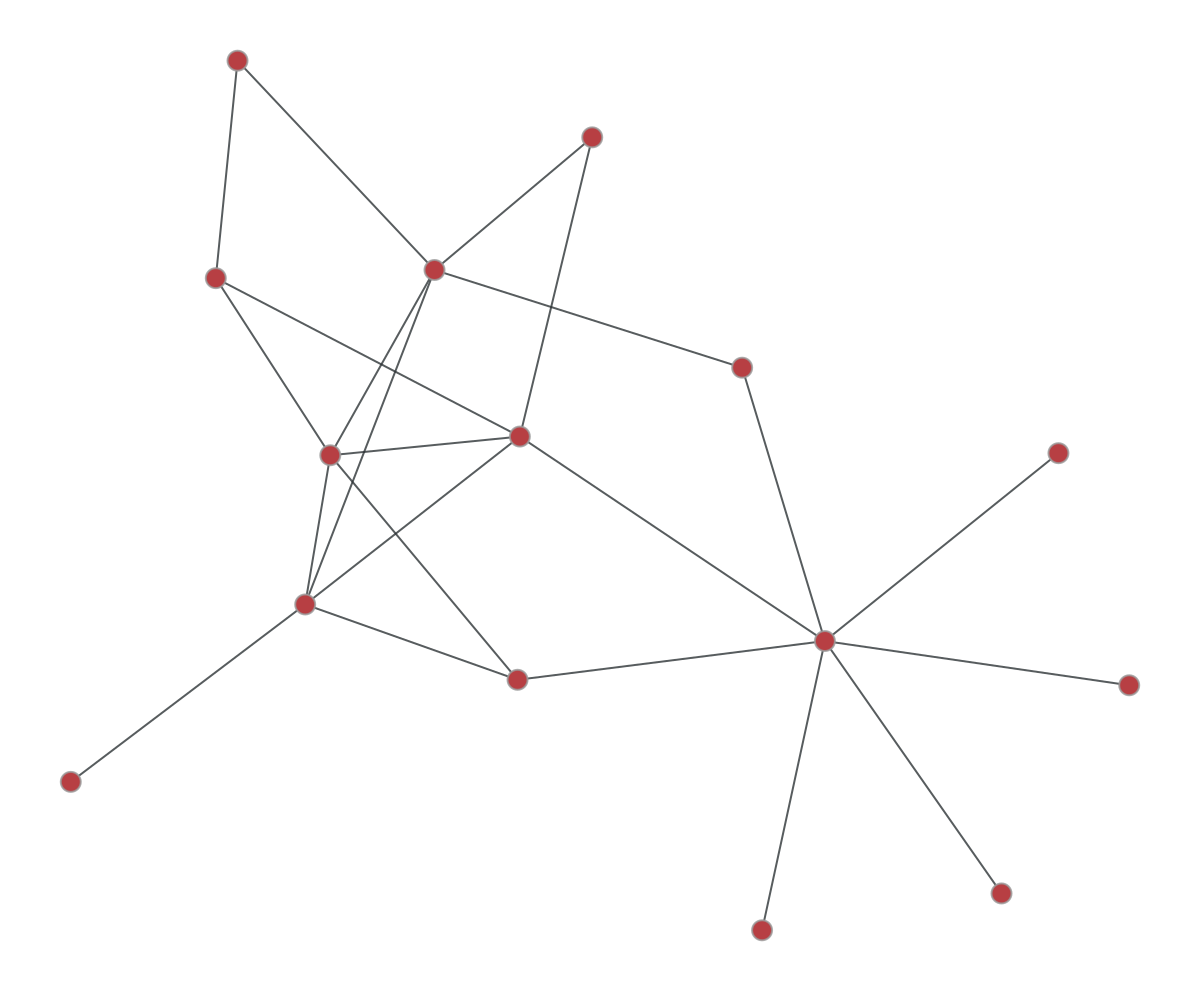

In [37]:
a=cairo_draw.graph_draw(g, pos=pos, bg_color="white", vcmap=cm.binary, vertex_size=10)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

<AxesSubplot: >

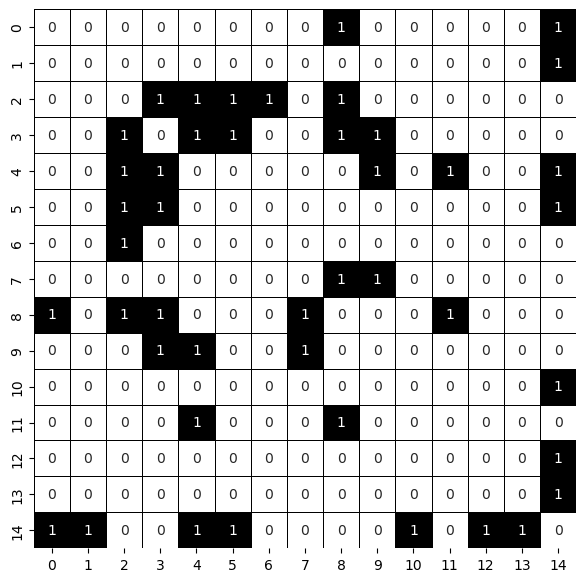

In [38]:
plt.figure(figsize=(7,7))
sns.heatmap(gt.spectral.adjacency(g).toarray(), cmap="binary", linewidths=0.5, linecolor="k", cbar=False, annot=True)
#plt.axis("off")

In [196]:
gt.generation.random_rewire(g)

18788

In [189]:
net.virus_list

['Human_rhinovirus_A_serotype_89']

In [29]:
aaa = g.new_vertex_property("bool",np.logical_not(np.isin(np.arange(len(order)),order[::-1][:10000])))

In [29]:
deg = g.degree_property_map("total")
deg.a = np.log(deg.a)

In [182]:
bet = gt.centrality.betweenness(g)[0]
bet.a = np.log2((bet.a+0.0001)*100)*1.5
bet.a = bet.a-min(bet.a)+1

In [183]:
max(pr.a)

11.296626068091676

In [184]:
pr = gt.centrality.pagerank(g)
pr.a = np.log10(pr.a*100000)*5
pr.a = pr.a-min(pr.a)+1

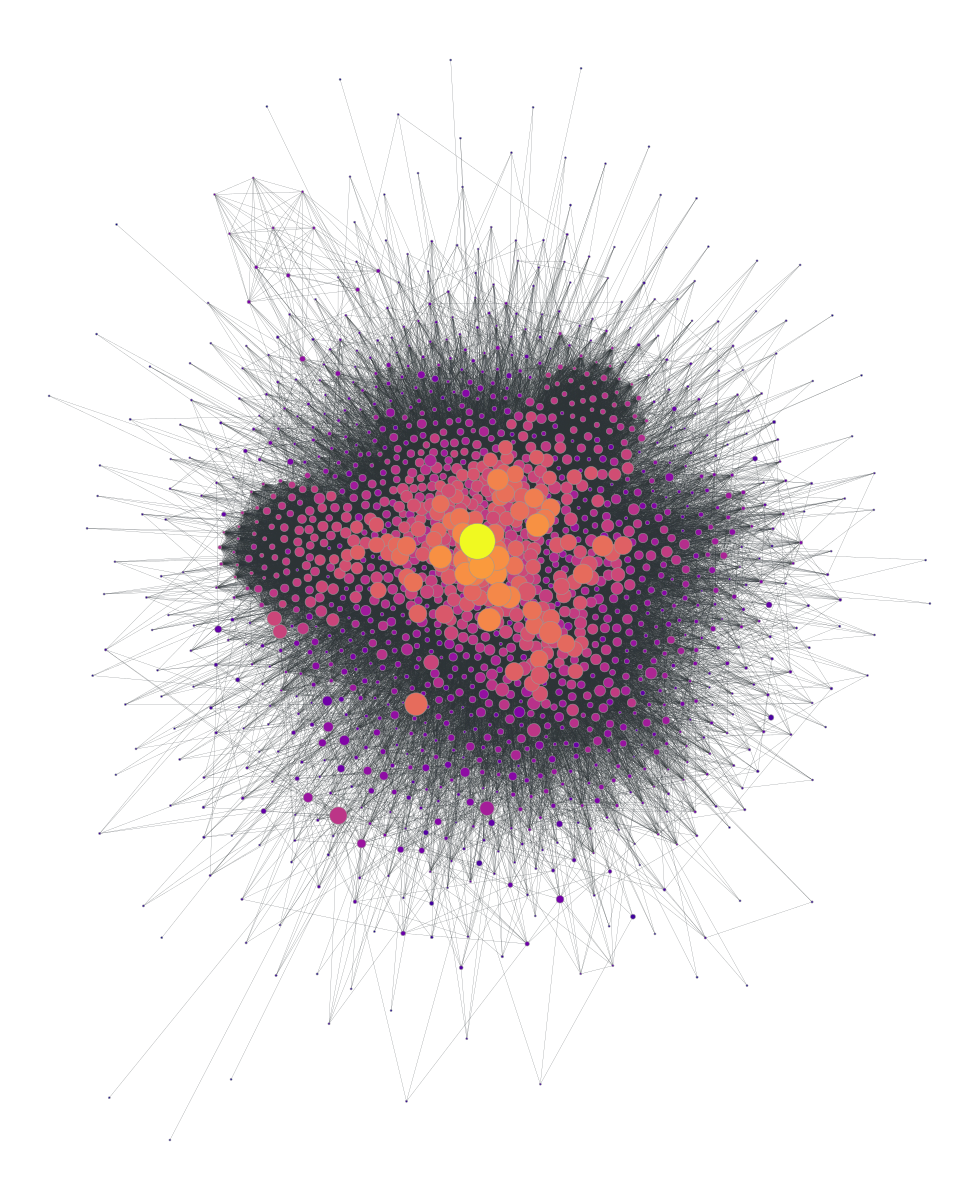

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6e8bfdc040, at 0x7f6e7a298c10>

In [187]:
cairo_draw.graph_draw(g, pos=pos, vertex_size=bet, vertex_fill_color=pr, vorder=bet, vcmap=cm.plasma, bg_color="white",
                     edge_pen_width=0.1)

In [73]:
size=centr['vers'].to_numpy()[order[::-1][:1000]]

In [76]:
size=gn.get_total_degrees(np.arange(g.num_vertices()))[order[::-1][:1000]]

In [77]:
size.shape

(1000,)

In [99]:
centr.sort_values("vers")

phy nodes      vers
1563       1563  0.008723
1566       1566  0.008723
1565       1565  0.008723
1564       1564  0.008723
1561       1561  0.008723
...         ...       ...
1063       1063  0.286467
1214       1214  0.290997
1306       1306  0.315932
1275       1275  0.327598
1334       1334  1.000000

[1569 rows x 2 columns]

In [139]:
np.maximum(size,0.)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint64)

In [348]:
net = mxp.VirusMultiplex(SamplingForNoco(10, group_dim=1)[9], target_folder=target_folder, virus_metadata=virus_metadata)

In [349]:
nT = mxp.build.get_node_tensor_from_network_list(net.g_list)
centr = mxp.versatility.get_multi_RW_centrality_edge_colored(nT)

In [350]:
order = centr.sort_values("vers")["phy nodes"].to_numpy()

In [351]:
perc = mxp.percolation.get_percolation(net.g_list, 4, net.Nodes, order=order)

In [352]:
pos = gt.draw.sfdp_layout(net.g_list[0])

In [353]:
positions = pos.get_2d_array([0,1])

In [33]:
positions[0].shape

(1569,)

In [41]:
gn.get_total_degrees([2])

array([2], dtype=uint64)

In [47]:
g.get_total_degrees([468])

array([27], dtype=uint64)

100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


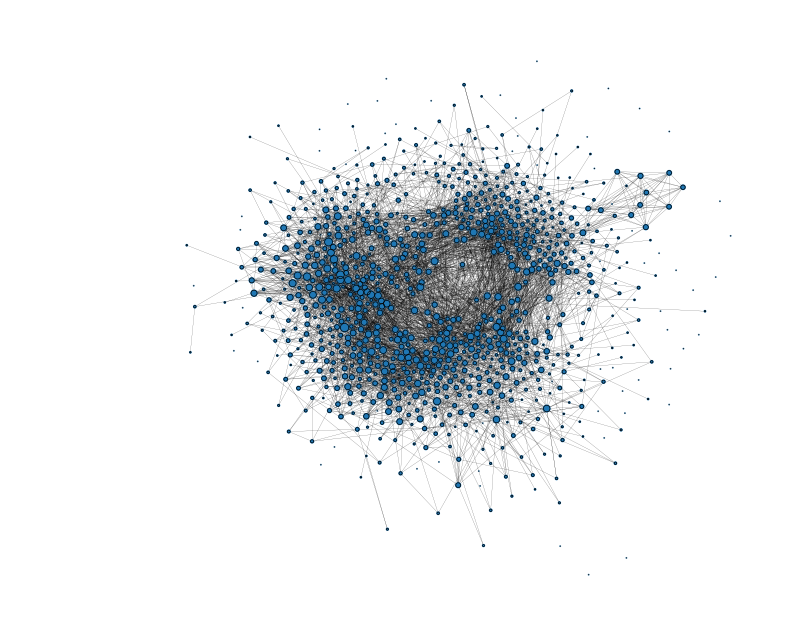

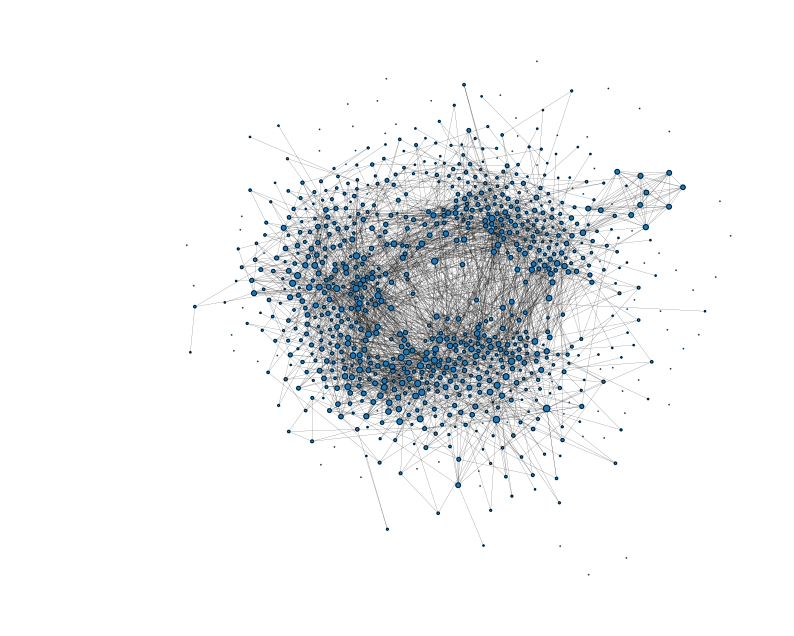

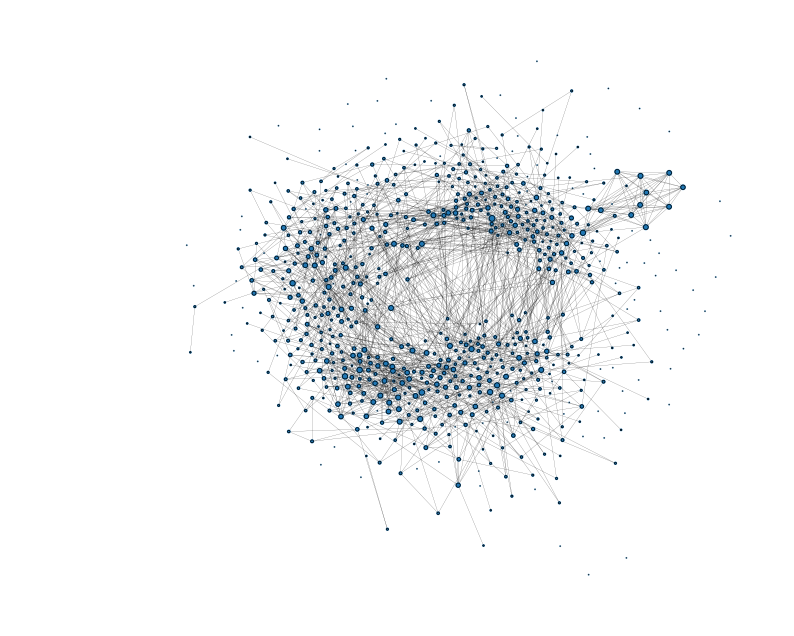

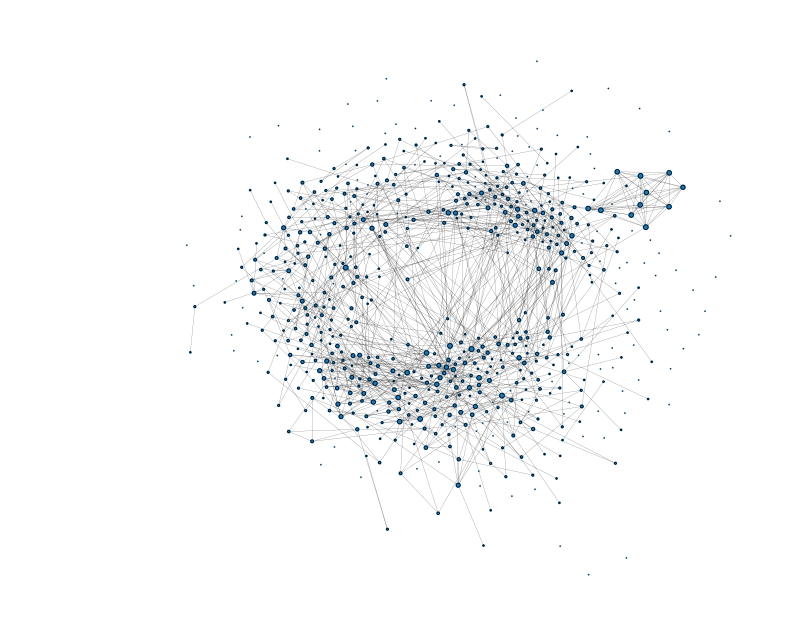

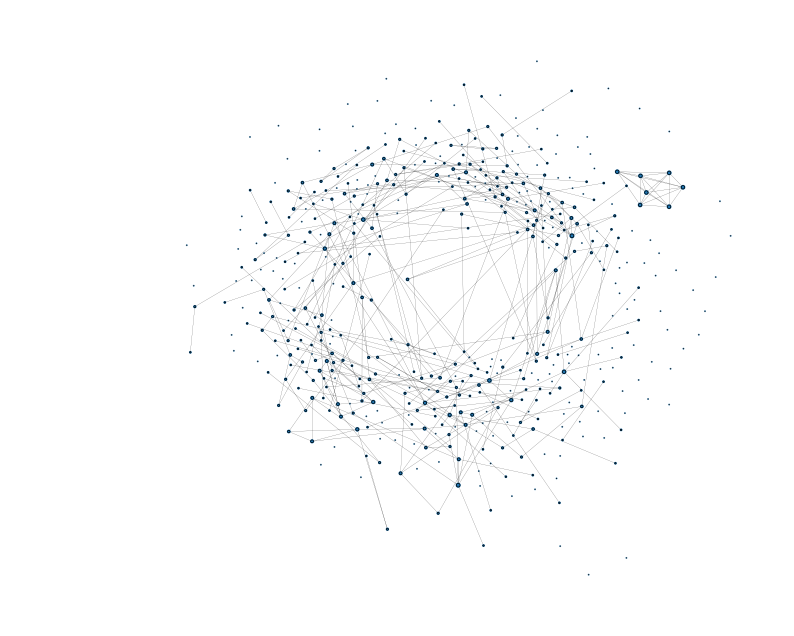

In [52]:
for p_init in tqdm([600,700,800,900,1050]):
    sel_nodes = np.sort(order[::-1][p_init:])
    gw = gt.GraphView(g, (np.isin(np.arange(len(order)), sel_nodes)))
    gn = gt.Graph(gw, prune=True)
    size=np.maximum(0.1,gn.get_total_degrees(np.arange(gn.num_vertices())))

    p_new = [positions[0][sel_nodes], positions[1][sel_nodes]]
    plt.figure(figsize=(10,8))
    for e in gn.get_edges():
        plt.plot([p_new[0][e[0]], p_new[0][e[1]]],[p_new[1][e[0]], p_new[1][e[1]]], c="k", lw=0.1)

    plt.scatter(p_new[0], p_new[1], s=size, zorder=2)
    plt.scatter(p_new[0], p_new[1] ,s=size, zorder=2, edgecolor='k', facecolor='none', lw=0.5)
    x_s=positions[0].max()-positions[0].min()
    y_s=positions[1].max()-positions[1].min()
    plt.xlim([positions[0].min()-0.1, positions[0].max()+0.1*x_s])
    plt.ylim([positions[1].min()-0.1*y_s, positions[1].max()+0.1*y_s])
    plt.axis("off")
    plt.savefig("../Images/net_"+str(p_init)+".png")


  0%|                                                     | 0/1 [00:00<?, ?it/s]

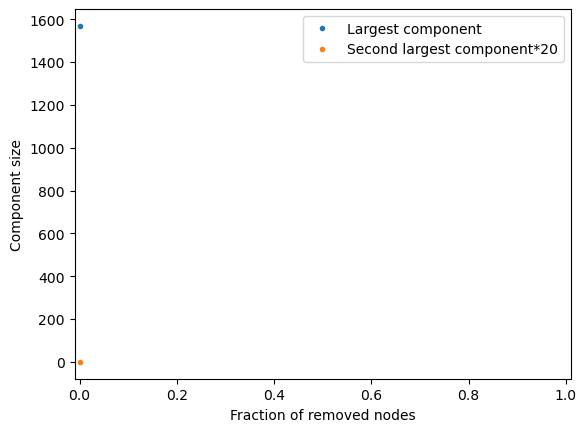

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


In [57]:
for p_init in tqdm([1]):
    plt.plot(np.linspace(0,1,len(perc['1ComponentSize']))[:p_init],perc['1ComponentSize'][::-1][:p_init], ".", label="Largest component")
    plt.plot(np.linspace(0,1,len(perc['1ComponentSize']))[:p_init],perc['2ComponentSize'][::-1][:p_init]*20, ".", label="Second largest component*20")
    plt.xlabel("Fraction of removed nodes")
    plt.ylabel("Component size")
    plt.xlim([-0.01,1.01])
    plt.legend()
    plt.savefig("../Images/perc_"+str(p_init)+".png")
    plt.show("off")

In [584]:
from sklearn.preprocessing import normalize

In [576]:
g= net.g_list[-1]

In [622]:
pos = gt.draw.sfdp_layout(g)
positions = pos.get_2d_array([0,1])

In [579]:
nt = mxp.build.get_node_tensor_from_network_list([g])
tra = mxp.build.build_supra_transition_matrix_from_supra_adjacency_matrix(nt[0],1,g.num_vertices())
traa=tra.T.toarray()

In [581]:
target_node = 100

In [619]:
mod_traa=np.copy(traa)
mod_traa[:,target_node]=0
mod_traa = normalize(mod_traa, axis=1,norm="l1")
mod_traa = mod_traa*0.9
mod_traa[:,target_node]=0.1
mod_traa.sum(axis=1).sum()

1569.0

In [625]:
egg, leig = sps.linalg.eigs(mod_traa.T, k=1, which='LR')
leig =abs(leig)[:,0]

In [636]:
props = g.new_vertex_property("double")

In [646]:
props.a = np.log(leig*10000)

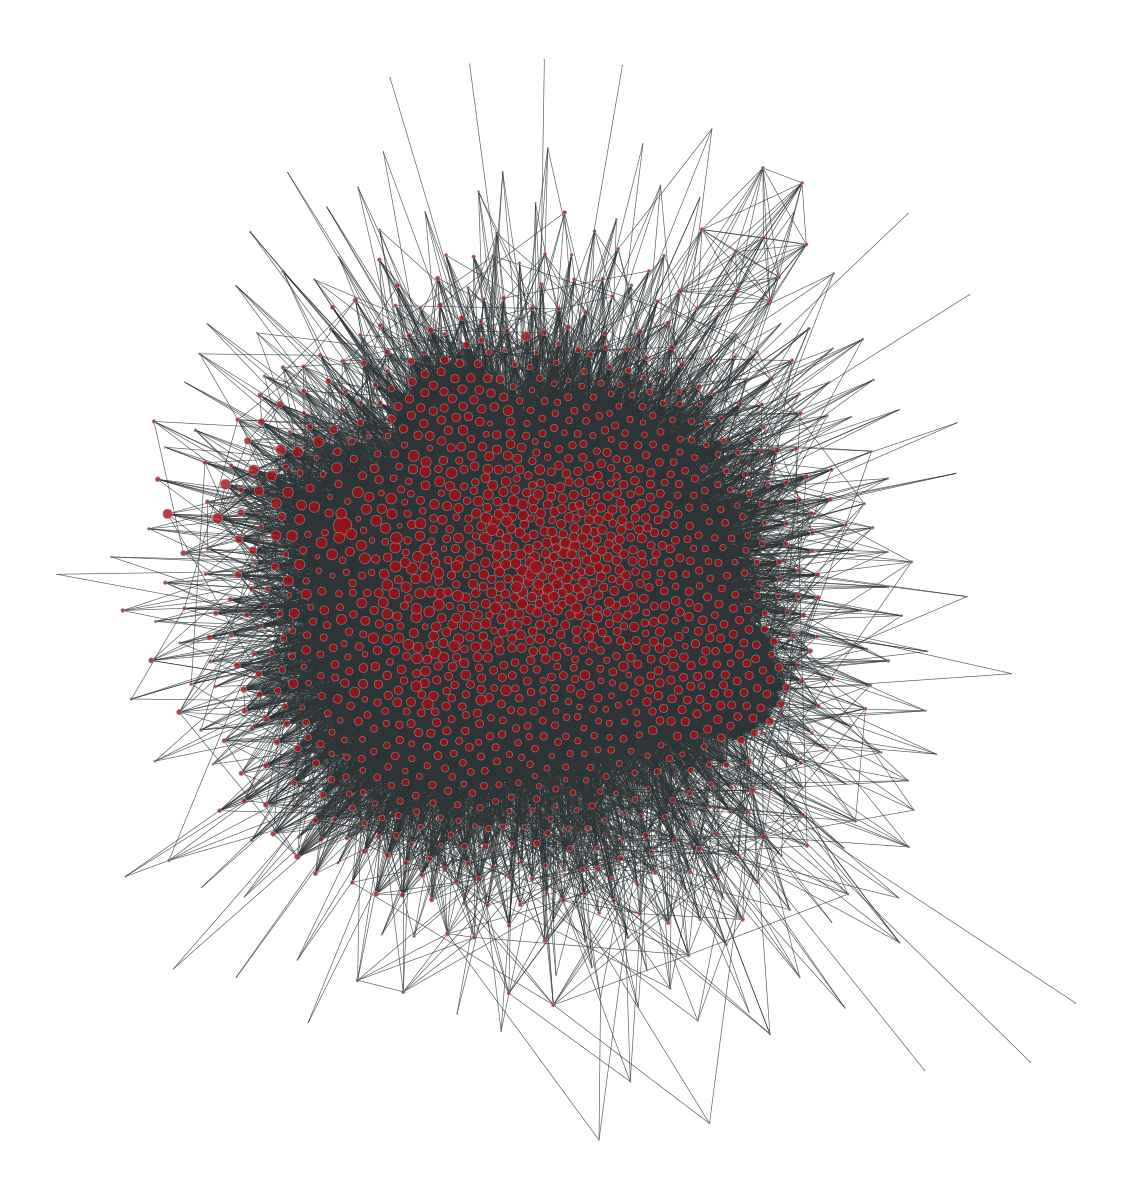

In [647]:
plt.figure(figsize=(10,8))
for e in g.get_edges():
    plt.plot([positions[0][e[0]], positions[0][e[1]]],[positions[1][e[0]], positions[1][e[1]]], c="k", lw=0.1,zorder=0)


plt.scatter(positions[0], positions[1], s=20, zorder=1, alpha=0.5, color="navy")
plt.scatter(positions[0], positions[1] ,s=10, zorder=1, edgecolor='k', facecolor='none', lw=0.5)

x_s=positions[0].max()-positions[0].min()
y_s=positions[1].max()-positions[1].min()
plt.xlim([positions[0].min()-0.1*x_s, positions[0].max()+0.1*x_s])
plt.ylim([positions[1].min()-0.1*y_s, positions[1].max()+0.1*y_s])
plt.axis("off")